In [72]:
using Distributions
using LinearAlgebra
using Plots
using Test
using Sobol
using Optim
using Random

In [74]:
include("rollout.jl")
include("testfns.jl")
include("utils.jl")

generate_batch

In [84]:
# Global parameters
BATCH_SIZE = 20
HORIZON = 0
MC_SAMPLES = 50 + HORIZON*50
BUDGET = 5;

In [76]:
# Setup toy problem
testfn = TestRosenbrock()
testfn.bounds[:, 1] = [-2 -1]
testfn.bounds[:, 2] = [2 3]
lbs, ubs = testfn.bounds[:,1], testfn.bounds[:,2]

# Setup low discrepancy random number stream
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON+1);
rns = randn(MC_SAMPLES, testfn.dim+1, HORIZON+1);

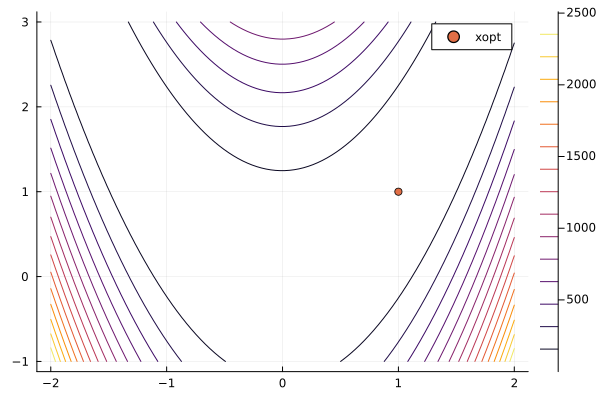

In [77]:
tplot(testfn)

In [78]:
# Gather initial samples/experimental data
N, θ = 1, [1.]
X = [-.5 2.]
X = reshape(X, testfn.dim, 1)
ψ = kernel_matern52(θ)
sur = fit_surrogate(ψ, X, testfn.f)
θ, sur = optimize_hypers(ψ.θ, kernel_matern52, sur.X, testfn.f);

### Visualize the Contours of the Underlying Objective

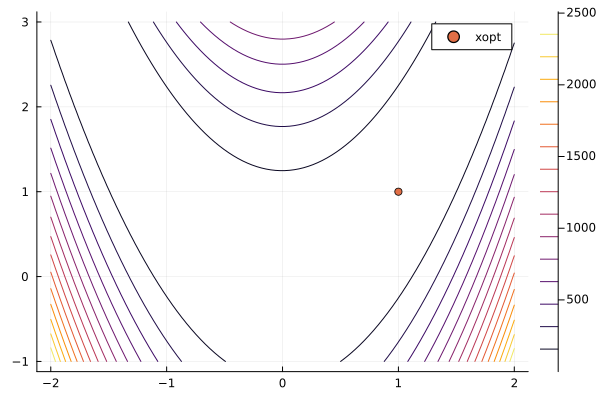

In [79]:
xx = range(-2, 2, length=100)
yy = range(-1, 3, length=100)
plot(xx, yy, (x,y) -> testfn.f([x,y]), st=:contour)
scatter!([testfn.xopt[1]], [testfn.xopt[2]], label="xopt")

### Visualize State of Belief from Surrogate Model

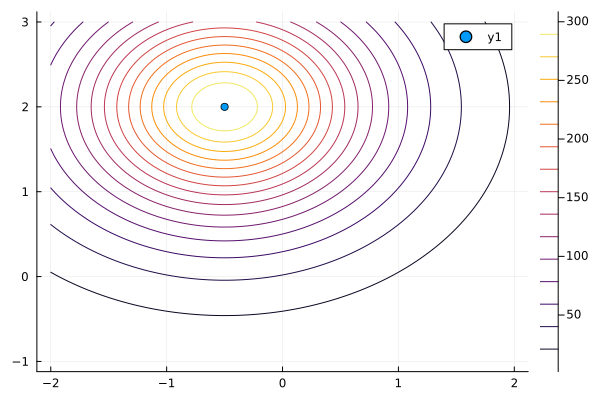

In [80]:
scatter(sur.X[1,:], sur.X[2,:])
plot!(xx, yy, (x,y) -> sur([x,y]).μ, st=:contour, label="μ")

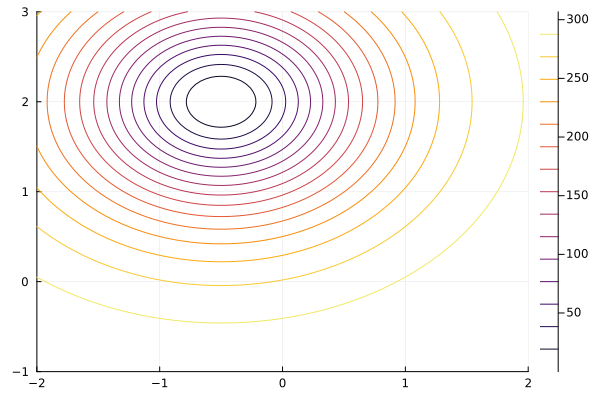

In [81]:
plot(xx, yy, (x,y) -> sur([x,y]).EI, st=:contour)

In [93]:
B = generate_batch(BATCH_SIZE, lbs=lbs, ubs=ubs)
for x0 in eachcol(B)
    x0 = convert(Vector{Float64}, x0)
    
    αxs, ∇αxs = [], []
    # Monte-carlo integrate trajectory for x0
    for sample in 1:MC_SAMPLES
        # Make a copy of our surrogate to pass to the trajectory struct
        # for fantasized computations
        fsur = Base.deepcopy(sur)
        fantasy_ndx = size(fsur.X, 2) + 1

        # Rollout trajectory
        T = Trajectory(fsur, x0, fantasy_ndx; h=HORIZON)
        rollout!(T, lbs, ubs; rnstream=lds_rns[sample,:,:])

        # Evaluate rolled out trajectory
        push!(αxs, α(T))
        push!(∇αxs, first(∇α(T)))
    end # endfor sample
end

LoadError: DimensionMismatch("dimensions must match: a has dims (Base.OneTo(2),), b has dims (Base.OneTo(1),), mismatch at 1")

In [94]:
function centered_fd(f, u, du, h)
    (f(u+h*du)-f(u-h*du))/(2h)
end

centered_fd (generic function with 1 method)

In [135]:
r = [2., 2.]
dr = rand(2)
h = 1e-6
f(x) = x[1]^2 + x[2]^2

f (generic function with 1 method)

In [138]:
Du = h * Matrix(I, 2, 2)
for i = 1:size(Du, 1)
    dr = Du[:, i]
    res = (f(r+dr) - f(r-dr))/2h
    println(res)
end

4.000000000115023
4.000000000115023
